# scIB score plots
Compare scIB scores across integration methods and datasets.

In [5]:
import pandas as pd
import numpy as np
import pickle as pkl
import glob

from sklearn.preprocessing import minmax_scale

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sb

In [6]:
BIO=['graph_cLISI','NMI','ARI','ASW_cell_type']
BATCH=['PC_regression','ASW_batch','kBET','graph_connectivity','graph_iLISI']

#### Load data

In [7]:
adata_name='adata_norm_integrated_forScib_a_p0.0r1.0-akl_0.1-aklq_0.1-ra_0-uh_0-b_study_sample-sd_False-dp_0.01-lr_0.001-hls_830.830.830-es_1-nh_10000-ne_500-dll_softplus-ule_False-mg_200-mig_3-aea_100-aeaq_None-wd_0.0.h5ad'
data_path='/storage/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/qtr/integrated/gsCellType_query/querySTZ_rmNodElimination/mo/'

In [38]:
data=[]
for adata_name,data_path,dataset,batch,cell_type in [
    ('adata_norm_integrated_forScib_a_p0.0r1.0-akl_0.1-aklq_0.1-ra_0-uh_0-b_study_sample-sd_False-dp_0.01-lr_0.001-hls_830.830.830-es_1-nh_10000-ne_500-dll_softplus-ule_False-mg_200-mig_3-aea_100-aeaq_None-wd_0.0.h5ad',
    '/storage/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/qtr/integrated/gsCellType_query/querySTZ_rmNodElimination/mo/',
    'pancreas','ref_query','cell_type'),
    ('kang_pbmc_le_control.h5ad',
     '/storage/groups/ml01/workspace/sergei.rybakov/pbmc_kang_metrics/',
     'pbmc','condition_joint','cell_type_joint')
    ]:
    for method in ['seurat','symphony','scvi','qtr']:
        files=glob.glob(data_path+'*scIB_IE_X_'+\
                      method+'_B_'+batch+'_CT_'+cell_type+'_uid*.pkl')
        if method=='qtr':
            files.extend(glob.glob(data_path+'*scIB_IE_X_cvae_B_'+\
                                   batch+'_CT_'+cell_type+'_uid*.pkl'))
        results_method=[]
        for file in files:
            res=pkl.load(open(file, 'rb'))
            if res['adata_name']==adata_name:
                results_method.append(res)
        if len(results_method)!=1:
            raise ValueError('Not exactly 1 result for method and adata, found %i results'%
                             len(results_method))
        else:
            res=results_method[0]
        res['method']=method
        res['dataset']=dataset
        del res['adata_name']
        data.append(res)
data=pd.DataFrame(data)

In [62]:
# Rename methods
data.replace({'method':{'seurat':'Seurat','symphony':'Symphony',
                        'scvi':'scVI','qtr':'Expimap'}},inplace=True)

In [63]:
display(data)

,PC_regression,ASW_batch,kBET,graph_connectivity,graph_iLISI,graph_cLISI,NMI,ARI,ASW_cell_type,method,dataset,bio,batch,overall
0,0.573865,0.898781,0.690482,0.902778,2.132982e-02,0.942469,0.726089,0.823011,0.557160,Seurat,pancreas,0.762182,0.617447,0.704288
1,0.366878,0.806508,0.672091,0.924151,2.322529e-02,0.980107,0.627244,0.552168,0.497128,Symphony,pancreas,0.664162,0.558571,0.621925
2,0.565996,0.843018,0.685764,0.920962,4.463912e-02,0.963410,0.745554,0.847091,0.452372,scVI,pancreas,0.752107,0.612076,0.696094
3,0.830916,0.849592,0.692612,0.950481,8.035245e-02,0.984566,0.749592,0.792801,0.476635,Expimap,pancreas,0.750899,0.680791,0.722855
4,0.301125,0.641337,0.006633,0.952870,0.000000e+00,0.922041,0.716216,0.654591,0.513468,Seurat,pbmc,0.701579,0.380393,0.573104
5,0.526308,0.630974,0.015751,0.932421,2.220446e-16,0.913067,0.694415,0.619372,0.549256,Symphony,pbmc,0.694027,0.421091,0.584853
6,0.804964,0.824839,0.085400,0.980285,1.134385e-02,0.866100,0.695296,0.636402,0.518656,scVI,pbmc,0.679114,0.541366,0.624015
7,0.878076,0.986585,0.436301,0.924207,1.848206e-01,0.287689,0.693683,0.624938,0.504167,Expimap,pbmc,0.527619,0.681998,0.589371


In [65]:
# Min-Max normalise scores within dataset
data_norm_group=data.copy()
for metric in BIO+BATCH:
    for dataset in data.dataset.unique():
        rows=data_norm_group.index[data_norm_group.dataset==dataset]
        data_norm_group.loc[rows,metric]=minmax_scale(data.loc[rows,metric].values.reshape(-1,1))

#### All scores

Plots of raw scores. Datasets are thus plotted separately. As most metrics have similar range across datasets and ylim is set to [0,1] they are plotted on the same figure.

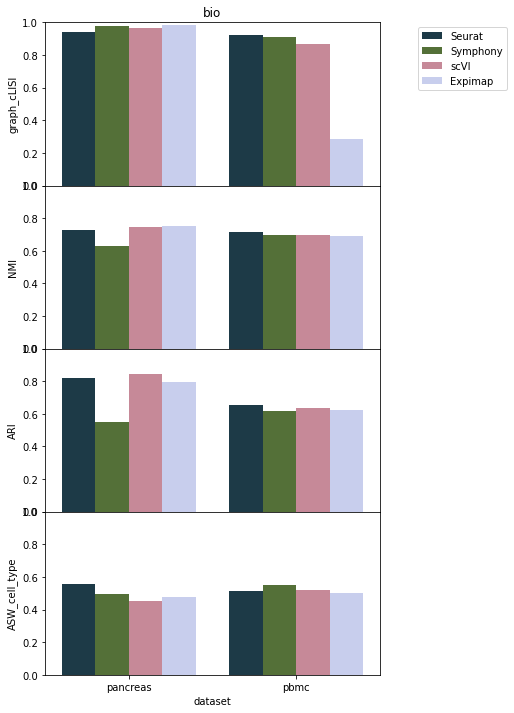

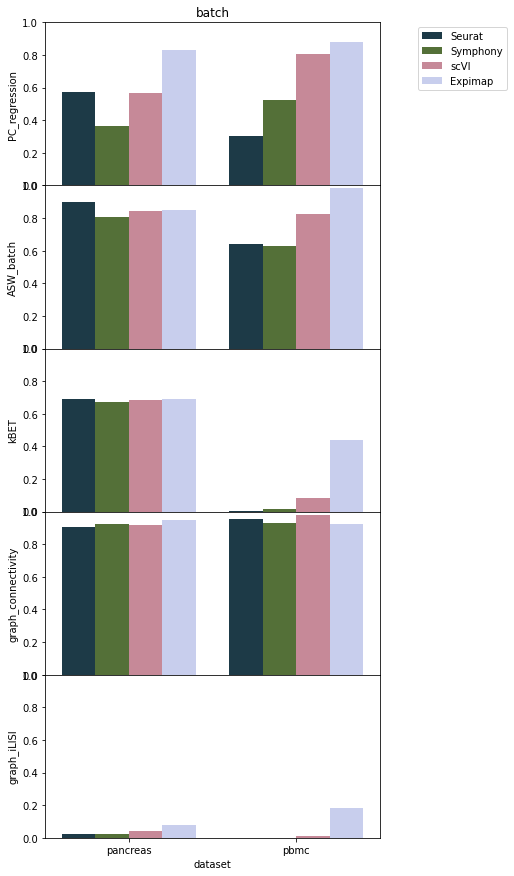

In [66]:
# Score values across datasets and methods
for name,metrics in {'bio':BIO,'batch':BATCH}.items():
    ncol=1
    nrow=len(metrics)
    fig,ax=plt.subplots(nrow,ncol,figsize=(6*ncol,3*nrow),sharex=True,
                        sharey=True
                       )
    ax[0].set_ylim(0,1)
    for idx,metric in enumerate(metrics):
        sb.barplot(x='dataset',y=metric,hue='method',
                       data=data,ax=ax[idx],palette='cubehelix')
        if idx!=0:
            ax[idx].legend_.remove()
        else:
             ax[idx].legend(bbox_to_anchor=(1.1, 1))
    ax[0].set_title(name)
    plt.subplots_adjust(wspace=0, hspace=0)

Plots of scores min-max normalised within datasets. Thus ranking of methods is easily comparable across datasets.

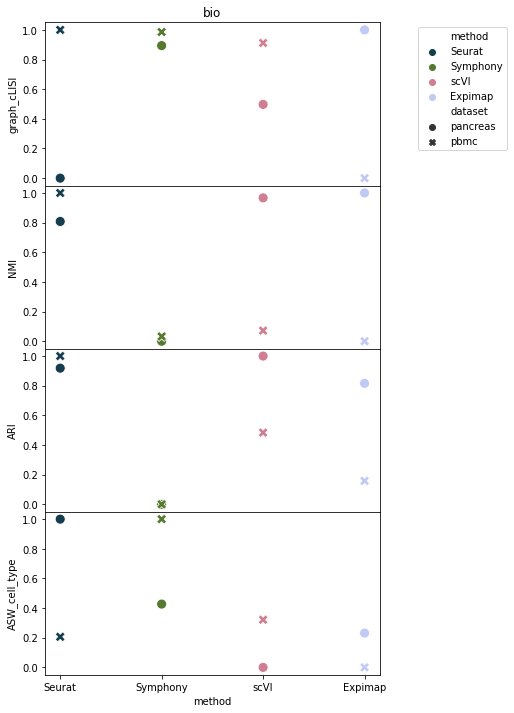

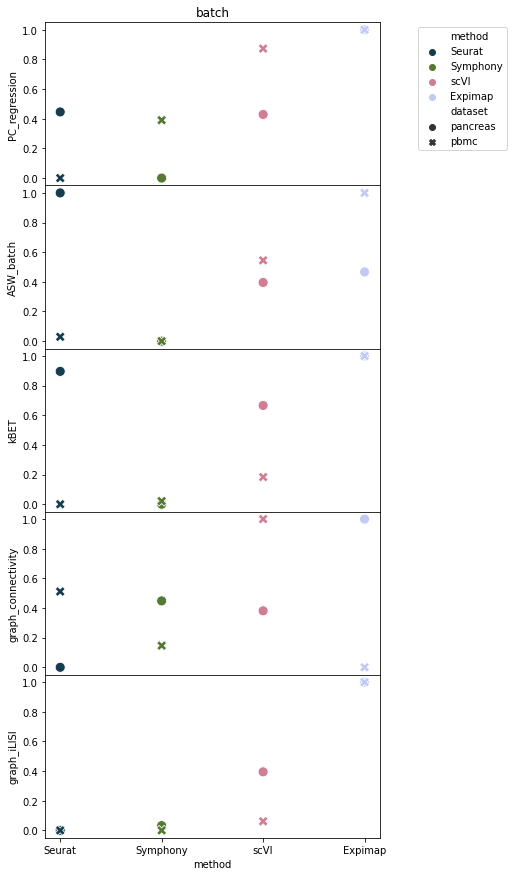

In [67]:
# Score values across datasets and methods
for name,metrics in {'bio':BIO,'batch':BATCH}.items():
    ncol=1
    nrow=len(metrics)
    fig,ax=plt.subplots(nrow,ncol,figsize=(6*ncol,3*nrow),sharex=True)
    for idx,metric in enumerate(metrics):
        sb.scatterplot(x='method',y=metric,hue='method',style='dataset',
                       data=data_norm_group,ax=ax[idx],s=100,palette='cubehelix')
        if idx!=0:
            ax[idx].legend_.remove()
        else:
             ax[idx].legend(bbox_to_anchor=(1.1, 1))
    ax[0].set_title(name)
    plt.subplots_adjust(wspace=0, hspace=0)

#### Summarised scores
Prepare summary scores.
Scores are min-max normalised within each dataset. Mean is computed for bio and batch scores and the overall scores is a weighetd average of bio and batch score.

In [68]:
# Compute summary metrics
# Unscaled
# Compute summary metrics
data['bio']=data[BIO].mean(axis=1)
data['batch']=data[BATCH].mean(axis=1)
data['overall']=data['bio']*0.6+data['batch']*0.4
# Scaled to [0,1]
data_norm_group['bio']=data_norm_group[BIO].mean(axis=1)
data_norm_group['batch']=data_norm_group[BATCH].mean(axis=1)
data_norm_group['overall']=data_norm_group['bio']*0.6+data_norm_group['batch']*0.4

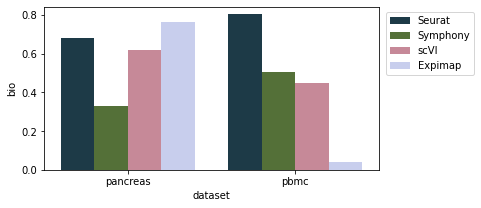

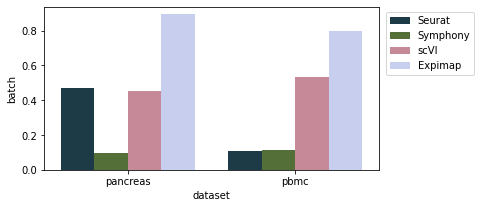

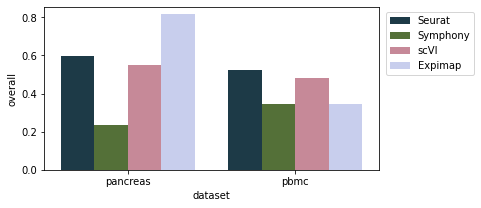

In [69]:
for summary in ['bio','batch','overall']:
    fig,ax=plt.subplots(figsize=(6,3))
    #sb.barplot(x='dataset',y=summary,hue='method',data=data_norm_group,ax=ax)
    sb.barplot(x='dataset',y=summary,hue='method',
                       data=data_norm_group,ax=ax,palette='cubehelix')
    ax.legend(bbox_to_anchor=(1.3, 1))

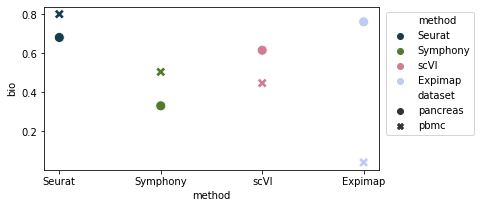

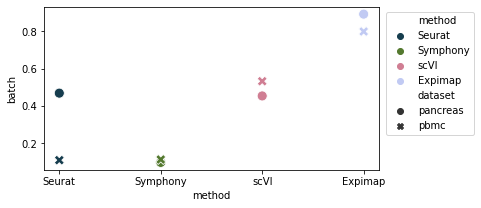

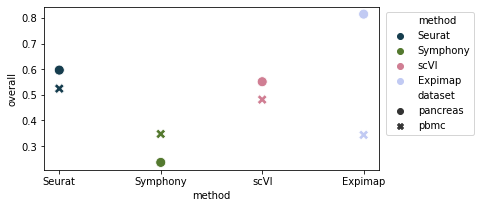

In [70]:
for summary in ['bio','batch','overall']:
    fig,ax=plt.subplots(figsize=(6,3))
    #sb.barplot(x='dataset',y=summary,hue='method',data=data_norm_group,ax=ax)
    sb.scatterplot(x='method',y=summary,hue='method',style='dataset',
                       data=data_norm_group,ax=ax,s=100,palette='cubehelix')
    ax.legend(bbox_to_anchor=(1.3, 1))

Bio vs batch 

Avg on [0,1] scaled scores

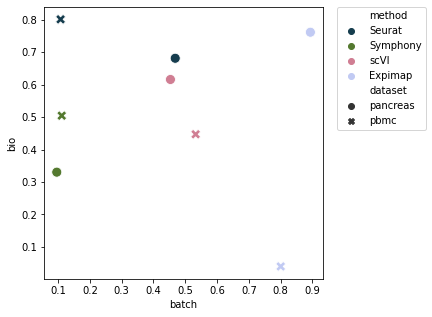

In [71]:
rcParams['figure.figsize']=(5,5)
sb.scatterplot(x='batch',y='bio',hue='method',style='dataset',s=100,
                       data=data_norm_group,palette='cubehelix')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Avg on unsclaed scores

(0.0, 1.0)

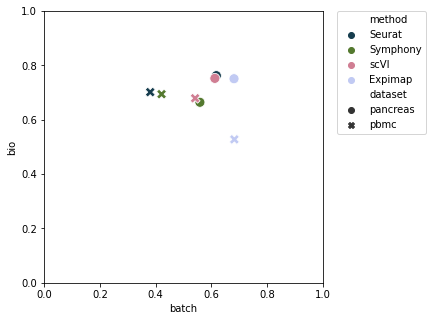

In [72]:
rcParams['figure.figsize']=(5,5)
sb.scatterplot(x='batch',y='bio',hue='method',style='dataset',s=100,
                       data=data,palette='cubehelix')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(0,1)
plt.ylim(0,1)